In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import os
import sys
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

from IPython.display import display, Markdown, Latex

import torch
from torch import nn
import torch.nn.functional as F

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [3]:
torch.manual_seed(33)

In [6]:
from simple_relational_reasoning.datagen import *
from simple_relational_reasoning.datagen import IdenticalObjectsRelation
from simple_relational_reasoning.models import MLPModel, RelationNetModel

from run import run
from run.run import FIELD_CONFIGURATIONS

In [7]:
FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save_plot(save_path, bbox_inches='tight'):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        print('Figure:\n')
        print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
        print('\nWrapfigure:\n')
        print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
        print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [8]:
from collections import namedtuple
VisualizationDefinition = namedtuple('VisualizationDefinition', ('name', 'patch_class', 'offset', 'patch_args'))
VISUALIZATION_DEFINITIONS = (
    VisualizationDefinition('square', mpatches.Rectangle, np.array([0, 0]), (10, 10)),
    VisualizationDefinition('circle', mpatches.Circle, np.array([5, 5]), (5, )),
    VisualizationDefinition('triangle', mpatches.RegularPolygon, np.array([5, 5]), (3, 6)),
    VisualizationDefinition('pentagon', mpatches.RegularPolygon, np.array([5, 5]), (5, 5.5)),
)


DEFAULT_PATCH_KWARGS = dict(ec='none')
DEFAULT_SCALE = 10


def object_to_patch(object_tensor, field_slices, 
                    x_field='x', y_field='y', 
                    color_field='color', shape_field='shape',
                    scale=DEFAULT_SCALE, additional_patch_kwargs=None, 
                    visualization_definitions=VISUALIZATION_DEFINITIONS):
    
    patch_kwargs = DEFAULT_PATCH_KWARGS.copy()
    if additional_patch_kwargs is not None: 
        patch_kwargs.update(additional_patch_kwargs)
    
    x = int(object_tensor[field_slices[x_field]])
    y = int(object_tensor[field_slices[y_field]])
    position = np.array([x, y]) * scale
    shape_index = int(torch.nonzero(object_tensor[field_slices[shape_field]]).squeeze())
    color_index = int(torch.nonzero(object_tensor[field_slices[color_field]]).squeeze())
    
    vis_def = visualization_definitions[shape_index]
    patch = vis_def.patch_class(position + vis_def.offset, *vis_def.patch_args,
                                **patch_kwargs)
    
    return patch, color_index


def visualize_objects(objects, object_generator, ax=None, x_field='x',
                      y_field='y', color_field='color', shape_field='shape',
                      scale=DEFAULT_SCALE, figsize=(6, 6), bg_color='black', 
                      additional_patch_kwargs=None, 
                      visualization_definitions=VISUALIZATION_DEFINITIONS,
                      cmap=plt.cm.tab10, clim=(0, 10)):
   
    call_show = False
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
        call_show = True

    x_gen = object_generator.field_generators[x_field]
    plt.xlim(x_gen.min_coord * scale, x_gen.max_coord * scale)
    y_gen = object_generator.field_generators[y_field]
    plt.ylim(y_gen.min_coord * scale, y_gen.max_coord * scale)
    ax.set_facecolor(bg_color)
    
    patches, colors = zip(*[object_to_patch(objects[i], object_generator.field_slices, 
                                            x_field=x_field, y_field=y_field, 
                                            color_field=color_field, shape_field=shape_field, 
                                            scale=scale, additional_patch_kwargs=additional_patch_kwargs,
                                            visualization_definitions=visualization_definitions)
                            for i in range(objects.shape[0])])
    
    collection = PatchCollection(patches, cmap=cmap) 
    collection.set_array(np.array(colors)) 
    collection.set_clim(*clim)
    ax.add_collection(collection)
    
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    if call_show:
        plt.show()
    

In [9]:
X = {}
y = {}
object_generators = {}
positive_indices = {}
negative_indices = {}

for num_objects in (5, 10):
    
    for i, relation in enumerate(run.RELATION_NAMES_TO_CLASSES):
        key = (num_objects, relation)
        
        relation_class = run.RELATION_NAMES_TO_CLASSES[relation]
        object_generator = object_gen.SmartBalancedBatchObjectGenerator(
            num_objects, run.FIELD_CONFIGURATIONS['default'], relation_class)
        object_generators[key] = object_generator
            
        X[key], y[key] = object_generator(100)
        y[key] = y[key].bool()
        
        positive_indices[key] = torch.nonzero(y[key]).squeeze()
        negative_indices[key] = torch.nonzero(~y[key]).squeeze()
                   


Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{figures/example_images_5.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:example-images-5}
% \vspace{-0.2in}
\end{figure}


Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{figures/example_images_5.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:example-images-5}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



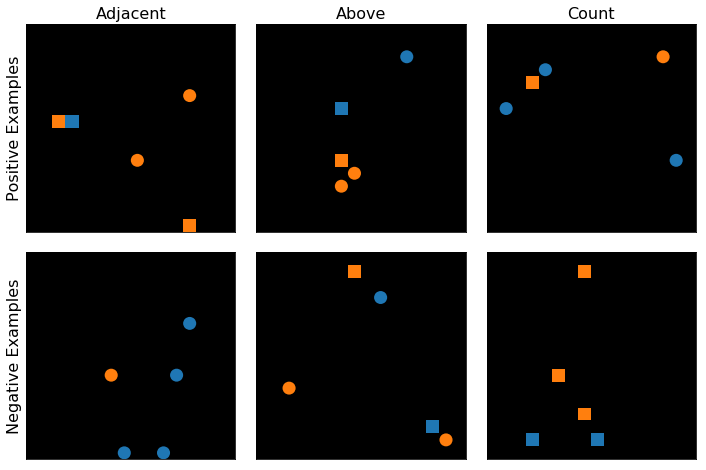

Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{figures/example_images_10.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:example-images-10}
% \vspace{-0.2in}
\end{figure}


Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{figures/example_images_10.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:example-images-10}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



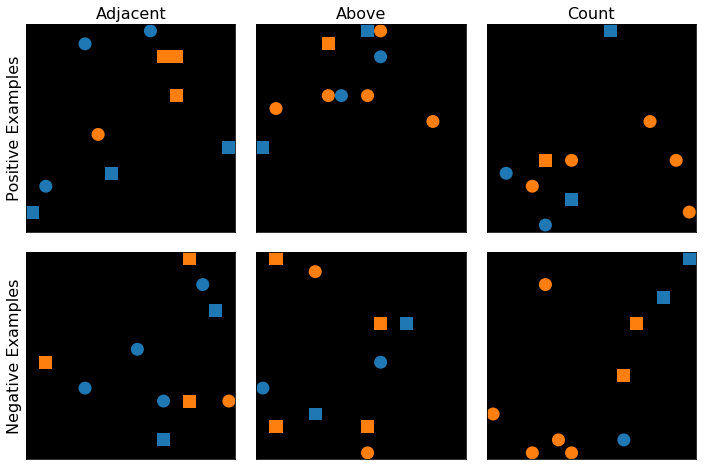

In [8]:
NUM_ROWS = 2
NUM_RELATIONS = len(run.RELATION_NAMES_TO_CLASSES)
FONTSIZE = 16

pos_idx_choices = defaultdict(lambda: 0)
neg_idx_choices = defaultdict(lambda: 0)

pos_idx_choices[(5, 'above')] = 1
pos_idx_choices[(5, 'count')] = 1

for num_objects in (5, 10):
    fig = plt.figure(figsize=(12, 8))
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    
    for i, relation in enumerate(run.RELATION_NAMES_TO_CLASSES):
        key = (num_objects, relation)
            
        pos_idx = positive_indices[key][pos_idx_choices[key]]
        neg_idx = negative_indices[key][neg_idx_choices[key]]
    
        pos_ax = plt.subplot(NUM_ROWS, NUM_RELATIONS, i + 1)
        if i == 0:
            pos_ax.set_ylabel('Positive Examples', fontsize=FONTSIZE)
        visualize_objects(X[key][pos_idx], object_generators[key], pos_ax)
        pos_ax.set_title(relation.title(), fontsize=FONTSIZE)
    
        neg_ax = plt.subplot(NUM_ROWS, NUM_RELATIONS, NUM_RELATIONS + i + 1)
        if i == 0:
            neg_ax.set_ylabel('Negative Examples', fontsize=FONTSIZE)
        visualize_objects(X[key][neg_idx], object_generators[key], neg_ax)
    
    save_plot(f'example_images_{num_objects}.pdf')
        
    plt.show()


# BetweenRelation

Is there an object of one color between two objects of the other color?

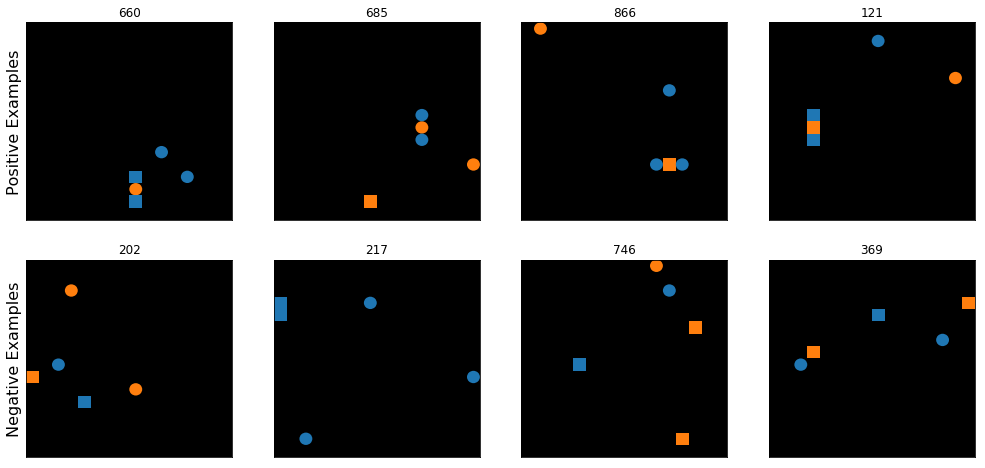

------

In [12]:
IMAGES_PER_LABEL = 4
N_OBJECTS = 5
FONTSIZE = 16

descriptions = {
    MultipleDAdjacentRelation: 'Are any two objects adjacent (L1 distance of 1)?',
    ColorAboveColorRelation: 'Is there a blue object above (or at the same height of) all orange objects?',
    ObjectCountRelation: 'Are there more blue objects than squares?',
    IdenticalObjectsRelation: 'Are any two objects identical (in shape and color)?',
    BetweenRelation: 'Is there an object of one color between two objects of the other color?'
}

X = {}
y = {}

for relation_class in (BetweenRelation, 
                       # MultipleDAdjacentRelation, ColorAboveColorRelation, ObjectCountRelation, 
#                        IdenticalObjectsRelation
                      ):
    fig = plt.figure(figsize=(4 * IMAGES_PER_LABEL + 1, 8))
    display(Markdown(f'# {relation_class.__name__}'))
    display(Markdown(descriptions[relation_class]))
    
    gen = object_gen.SmartBalancedBatchObjectGenerator(N_OBJECTS, run.FIELD_CONFIGURATIONS['default'], relation_class,
                                                       object_dtype=torch.float, label_dtype=torch.long,
                                                       max_recursion_depth=100
                                                      )

    X[relation_class], y[relation_class] = gen(1000)
    y[relation_class] = y[relation_class].bool()
    positive_indices = np.random.choice(torch.nonzero(y[relation_class]).squeeze(), size=4, replace=False)
    negative_indices = np.random.choice(torch.nonzero(~y[relation_class]).squeeze(), size=4, replace=False)
    
    for i, idx in enumerate(positive_indices):
        ax = plt.subplot(2, IMAGES_PER_LABEL, i + 1)
        if i == 0:
            ax.set_ylabel('Positive Examples', fontsize=FONTSIZE)
            
        visualize_objects(X[relation_class][idx], gen, ax)
        ax.set_title(idx)

        
    for i, idx in enumerate(negative_indices):
        ax = plt.subplot(2, IMAGES_PER_LABEL, i + IMAGES_PER_LABEL + 1)
        if i == 0:
            ax.set_ylabel('Negative Examples', fontsize=FONTSIZE)
            
        visualize_objects(X[relation_class][idx], gen, ax)
        ax.set_title(idx)
        
    plt.show()
    display(Markdown(f'------'))

# Dataset generation details

* We generate a dataset of $M$ images, each with $N$ objects to be balanced with respect to a particular relation.
* Each relation class (see the implementations in `object_relations.py`) knows how to convert a negative example to a positive, but not vice versa. That is, we can change a collections of objects where a relation doesn't hold to one where it does.
* First, we sample $M$ images randomly. 
* If more than $M / 2$ are positive (with respect to the given relation), we resample all of the positive ones, repeating until at least $M / 2$ are negative.
* We now have $M_{neg} > M / 2$ negative images. We convert $M_{neg} - M / 2$ of them to be positive, guaranteeing our dataset is balanced 50/50.
* The logic above is implemented in the `SmartBalancedBatchObjectGenerator` class in `object_gen.py`.


In [13]:
gen = object_gen.SmartBalancedBatchObjectGenerator(4, run.FIELD_CONFIGURATIONS['default'], BetweenRelation,
                                                       object_dtype=torch.float, label_dtype=torch.long,
                                                       max_recursion_depth=100)

no_constraints_gen = object_gen.SmartBalancedBatchObjectGenerator(4, run.FIELD_CONFIGURATIONS['default'], BetweenRelation,
                                                       object_dtype=torch.float, label_dtype=torch.long, constraints=[],
                                                       max_recursion_depth=100)

In [15]:
DEFAULT_POSITION_FIELDS = ('x', 'y')


def current_no_position_collision_constraint(object_batch, relevant_indices, field_slices,
                                     position_fields=DEFAULT_POSITION_FIELDS):
    violating_indices = []

    if relevant_indices is None:
        relevant_indices = range(object_batch.shape[0])

    for idx in relevant_indices:
        object_positions = torch.cat([object_batch[idx, :, field_slices[pos]] for pos in position_fields],
                                     dim=1).to(torch.float)

        for obj_idx in range(object_positions.shape[0] - 1):
            if (object_positions[obj_idx + 1:] == object_positions[obj_idx]).all(dim=1).any():
                violating_indices.append(idx)
                break

    return violating_indices

In [18]:
X = no_constraints_gen(1000)[0]


[68, 73, 281, 314, 359, 371, 480, 543, 832, 985]

In [20]:
X[current_no_position_collision_constraint(X, None, no_constraints_gen.field_slices)]

tensor([[[13.,  1.,  0.,  1.,  1.,  0.],
         [ 5.,  1.,  1.,  0.,  0.,  1.],
         [ 5.,  1.,  0.,  1.,  1.,  0.],
         [ 5.,  6.,  1.,  0.,  1.,  0.]],

        [[10.,  0.,  0.,  1.,  0.,  1.],
         [14.,  0.,  1.,  0.,  0.,  1.],
         [ 8., 15.,  1.,  0.,  0.,  1.],
         [10.,  0.,  0.,  1.,  0.,  1.]],

        [[ 4., 10.,  1.,  0.,  0.,  1.],
         [ 6., 10.,  1.,  0.,  1.,  0.],
         [ 5., 10.,  0.,  1.,  1.,  0.],
         [ 4., 10.,  0.,  1.,  1.,  0.]],

        [[ 8., 10.,  1.,  0.,  0.,  1.],
         [ 3.,  8.,  1.,  0.,  1.,  0.],
         [ 3.,  8.,  1.,  0.,  0.,  1.],
         [ 6., 12.,  0.,  1.,  1.,  0.]],

        [[ 7.,  3.,  1.,  0.,  0.,  1.],
         [ 2.,  3.,  0.,  1.,  0.,  1.],
         [12.,  0.,  0.,  1.,  0.,  1.],
         [12.,  0.,  1.,  0.,  0.,  1.]],

        [[11.,  2.,  1.,  0.,  1.,  0.],
         [13.,  5.,  1.,  0.,  0.,  1.],
         [13.,  5.,  1.,  0.,  1.,  0.],
         [10.,  0.,  1.,  0.,  1.,  0.]],

    

In [49]:
def previous_no_position_collision_constraint(object_batch, relevant_indices, field_slices,
                                     position_fields=DEFAULT_POSITION_FIELDS):
    violating_indices = []

    if relevant_indices is None:
        relevant_indices = range(object_batch.shape[0])

    for idx in relevant_indices:
        object_positions = torch.cat([object_batch[idx, :, field_slices[pos]] for pos in position_fields],
                                     dim=1).to(torch.float).unsqueeze(0)
#         print('P', object_positions)
        for obj_idx in range(object_positions.shape[0] - 1):
#             print(obj_idx, object_positions[obj_idx])
#             print(object_positions[obj_idx + 1:])
            if (object_positions[obj_idx + 1:] == object_positions[obj_idx]).any():
                violating_indices.append(idx)
                break
                
    return violating_indices

In [40]:
ind = previous_no_position_collision_constraint(X, [0, 1, 2], no_constraints_gen.field_slices)
print(ind)
X[ind]

P tensor([[[5., 4.],
         [5., 3.],
         [0., 8.],
         [5., 5.]]])
P tensor([[[ 4.,  6.],
         [ 5., 12.],
         [ 5., 13.],
         [ 5., 11.]]])
P tensor([[[15., 10.],
         [ 7., 11.],
         [ 0.,  6.],
         [ 8., 15.]]])
[]


tensor([], size=(0, 4, 6))

In [33]:
t = torch.tensor([[ 3.,  8.,  0.,  1.,  0.,  1.],
          [ 9.,  0.,  1.,  0.,  1.,  0.],
          [ 5.,  4.,  1.,  0.,  1.,  0.],
          [10., 12.,  0.,  1.,  1.,  0.]]).unsqueeze(0)
previous_no_position_collision_constraint(t, None, no_constraints_gen.field_slices)

[]

In [48]:
t[0, :, :2].unique(dim=0)

tensor([[ 3.,  8.],
        [ 5.,  4.],
        [ 9.,  0.],
        [10., 12.]])

In [58]:
constraint_sets = ([], [previous_no_position_collision_constraint], [current_no_position_collision_constraint])
names = ('None', 'Buggy', 'Fixed')
N = 10000

for n_obj in (5, 10):
    print(f'With {n_obj} objects:')
    for constraint_set, name in zip(constraint_sets, names):
        gen = object_gen.SmartBalancedBatchObjectGenerator(n_obj, run.FIELD_CONFIGURATIONS['default'], 
                                                           MultipleDAdjacentRelation,
                                                           object_dtype=torch.float, 
                                                           label_dtype=torch.long, 
                                                           constraints=constraint_set,
                                                           max_recursion_depth=100)
        X = gen(N)[0]
        unique_counts = defaultdict(lambda: 0)
        for b in range(X.shape[0]):
            pos = X[b, :, :2]
            unique_pos = set([tuple(x.numpy()) for x in pos])
            unique_counts[len(unique_pos)] += 1

        print(f'{name}: P(no collisions) = {unique_counts[n_obj] / N:.4f} [{unique_counts.items()}]')

With 5 objects:
None: P(no collisions) = 0.9704 [dict_items([(5, 9704), (4, 292), (3, 4)])]
Buggy: P(no collisions) = 0.9683 [dict_items([(5, 9683), (3, 5), (4, 312)])]
Fixed: P(no collisions) = 1.0000 [dict_items([(5, 10000)])]
With 10 objects:
None: P(no collisions) = 0.8366 [dict_items([(10, 8366), (9, 1523), (8, 106), (7, 5)])]
Buggy: P(no collisions) = 0.8387 [dict_items([(10, 8387), (9, 1504), (8, 108), (7, 1)])]
Fixed: P(no collisions) = 1.0000 [dict_items([(10, 10000)])]


In [59]:
gen.relation

In [63]:
objs = t.squeeze(0)
objs[2, :2] = torch.tensor([3, 8])

In [65]:
gen.relation.evaluate(objs)

tensor(False)